<a href="https://colab.research.google.com/github/rzagni/Fintech/blob/main/yfinance_embeddings_clustering_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [1]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [3]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import yfinance as yf
import time
from IPython.display import clear_output
from datetime import datetime

## Get the list of stocks in the S&P 500

In [20]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

df_tickers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 502 non-null    object
 1   Security               502 non-null    object
 2   GICS Sector            502 non-null    object
 3   GICS Sub-Industry      502 non-null    object
 4   Headquarters Location  502 non-null    object
 5   Date added             502 non-null    object
 6   CIK                    502 non-null    int64 
 7   Founded                502 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.5+ KB


In [21]:
df_tickers.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [22]:
# Convert ticker symbols to list for next processing steps
ticker_list = df_tickers['Symbol'].tolist()

## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [23]:
def get_news(ticker_list, news_dict=None, max_attempts=10, delay=0.5):
    """
    Get financial news for a list of stock tickers using yfinance.

    Parameters
    ----------
    ticker_list : list of str
        List of stock ticker symbols to fetch news for.
    news_dict : dict, optional
        Existing dictionary of previously fetched news.
    max_attempts : int, default=10
        Maximum retry attempts for failed tickers.
    delay : float, default=0.5
        Delay in seconds between API calls.

    Returns
    -------
    news_dict : dict
        Dictionary mapping tickers to lists of news articles.
    remaining : list of str
        Tickers that still failed after all retry attempts.
    """
    if news_dict is None:
        news_dict = {}

    remaining = ticker_list.copy()
    attempt = 1

    while remaining and attempt <= max_attempts:
        failed = []
        total = len(remaining)

        for idx, ticker in enumerate(remaining, 1):
            clear_output(wait=True)
            print(f"[Attempt {attempt}] Processing: {ticker}")
            print(f"Processed: {idx} of {total} | Errors: {len(failed)}")

            try:
                stock = yf.Ticker(ticker)
                news = stock.news
                if news is None:
                    raise ValueError("yfinance returned None for news")

                news_dict[ticker] = news
            except Exception as e:
                failed.append(ticker)

            time.sleep(delay)

        print(f"\nAttempt {attempt} complete. {len(failed)} tickers failed.\n")

        if not failed:
            break

        remaining = failed
        attempt += 1

    return news_dict, remaining


In [24]:
news_dict, still_failed = get_news(ticker_list)

if still_failed:
    print(f"Tickers failed after retries: {still_failed}")
else:
    print("All tickers processed successfully!")

[Attempt 1] Processing: ZTS
Processed: 502 of 502 | Errors: 0

Attempt 1 complete. 0 tickers failed.

Tickers failed after retries: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'COIN', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CE

CHECK WHY 502 INSTEAD OF 503

### Structure the news into a pandas dataframe

Your final dataframe should have the following columns:
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [28]:
from datetime import datetime

rows = []

for ticker, articles in news_dict.items():
    if not articles:
        continue

    for article in articles:
        content = article.get('content') or {}

        title = content.get('title', '').strip()
        summary = content.get('summary', '').strip()

        # Attempt to get a URL from any of the potential sources
        url = (
            (content.get('clickThroughUrl') or {}).get('url') or
            content.get('previewUrl') or
            (content.get('canonicalUrl') or {}).get('url') or
            ''
        ).strip()

        # Parse publication date
        pub_date_str = content.get('pubDate', '').strip()
        try:
            pub_date = datetime.strptime(pub_date_str, "%Y-%m-%dT%H:%M:%SZ")
            formatted_date = pub_date.strftime('%d-%b-%y')
        except Exception:
            formatted_date = ''

        # Keep article only if it has at least a title or a summary
        if not title and not summary:
            continue

        rows.append({
            'TICKER': ticker,
            'TITLE': title,
            'SUMMARY': summary,
            'PUBLICATION_DATE': formatted_date,
            'URL': url
        })


df_news = pd.DataFrame(rows)

In [30]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5004 entries, 0 to 5003
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TICKER            5004 non-null   object
 1   TITLE             5004 non-null   object
 2   SUMMARY           5004 non-null   object
 3   PUBLICATION_DATE  5004 non-null   object
 4   URL               5004 non-null   object
dtypes: object(5)
memory usage: 195.6+ KB


In [29]:
# Review the first 5 articles
df_news.head()


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",21-Jul-25,https://finance.yahoo.com/news/zacks-industry-...
1,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,21-Jul-25,https://finance.yahoo.com/news/stock-market-ne...
2,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,19-Jul-25,https://finance.yahoo.com/news/3m-co-mmm-q2-20...
3,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,19-Jul-25,https://finance.yahoo.com/news/mmm-q1-deep-div...
4,MMM,Dow Falls as Trump Reportedly Seeks Higher EU ...,The Dow Jones Industrial Average fell Friday f...,18-Jul-25,https://finance.yahoo.com/news/dow-falls-trump...


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- You should combine the title and summary into one string that you will embed together
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [31]:
# Loading the pre-trained embedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Combining TITLE and SUMMARY into a string
df_news['EMBEDDED_TEXT'] = (
    df_news['TITLE'].fillna('') + ' ' + df_news['SUMMARY'].fillna('')
)



In [33]:
# Let's look at one of the embedded_text
df_news['EMBEDDED_TEXT'][5]

'3M Gives Investors a ‘Beat and Raise.’ The Stock Is Rising. 3M  traded higher initially after reporting better-than-expected second-quarter earnings, but gave up gains throughout the day.  Wall Street was looking for earnings per share of $2.01 on sales of $6.1 billion, according to FactSet.  “We delivered strong results in the second quarter, posting positive organic sales growth and double-digit EPS growth,” said CEO William Brown in a news release.'

In [34]:
# Generate embeddings
embeddings = model.encode(df_news['EMBEDDED_TEXT'].tolist(), show_progress_bar=True)

# Store embeddings in the DataFrame
df_news['EMBEDDINGS'] = embeddings.tolist()

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [35]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5004 entries, 0 to 5003
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TICKER            5004 non-null   object
 1   TITLE             5004 non-null   object
 2   SUMMARY           5004 non-null   object
 3   PUBLICATION_DATE  5004 non-null   object
 4   URL               5004 non-null   object
 5   EMBEDDED_TEXT     5004 non-null   object
 6   EMBEDDINGS        5004 non-null   object
dtypes: object(7)
memory usage: 273.8+ KB


In [40]:
len(df_news.EMBEDDINGS[7])

384

## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [41]:
# Keep only the first article per TICKER
df_news_unique = df_news.drop_duplicates(subset='TICKER', keep='first').reset_index(drop=True)

In [42]:
df_news_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TICKER            501 non-null    object
 1   TITLE             501 non-null    object
 2   SUMMARY           501 non-null    object
 3   PUBLICATION_DATE  501 non-null    object
 4   URL               501 non-null    object
 5   EMBEDDED_TEXT     501 non-null    object
 6   EMBEDDINGS        501 non-null    object
dtypes: object(7)
memory usage: 27.5+ KB


In [43]:
# Let's verify
print(f"Unique tickers: {df_news_unique['TICKER'].nunique()}")
print(f"Total rows: {len(df_news_unique)}")

Unique tickers: 501
Total rows: 501


In [44]:
tickers_with_news = set(df_news['TICKER'])
all_tickers = set(news_dict.keys())
missing_tickers = sorted(all_tickers - tickers_with_news)

print(f"Missing {len(missing_tickers)} tickers:")
print(missing_tickers)

Missing 1 tickers:
['BF.B']


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Assume df_news has an 'EMBEDDINGS' column with list-like embeddings
# Convert list of embeddings into a 2D numpy array
embedding_matrix = np.vstack(df_news_unique['EMBEDDINGS'].values)

# Store results
cluster_results = {}

for k in range(1, 7):
    print(f"\nClustering with k={k}")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(embedding_matrix)

    df_news_unique[f'CLUSTER_{k}'] = cluster_labels

    if k > 1:
        score = silhouette_score(embedding_matrix, cluster_labels)
        print(f"Silhouette Score (k={k}): {score:.4f}")
        cluster_results[k] = {
            'labels': cluster_labels,
            'score': score,
            'model': kmeans
        }
    else:
        print("Silhouette score not defined for k=1")
        cluster_results[k] = {
            'labels': cluster_labels,
            'score': None,
            'model': kmeans
        }



Clustering with k=1
Silhouette score not defined for k=1

Clustering with k=2
Silhouette Score (k=2): 0.0406

Clustering with k=3
Silhouette Score (k=3): 0.0450

Clustering with k=4
Silhouette Score (k=4): 0.0453

Clustering with k=5
Silhouette Score (k=5): 0.0245

Clustering with k=6
Silhouette Score (k=6): 0.0242


#### Plot silhouette scores

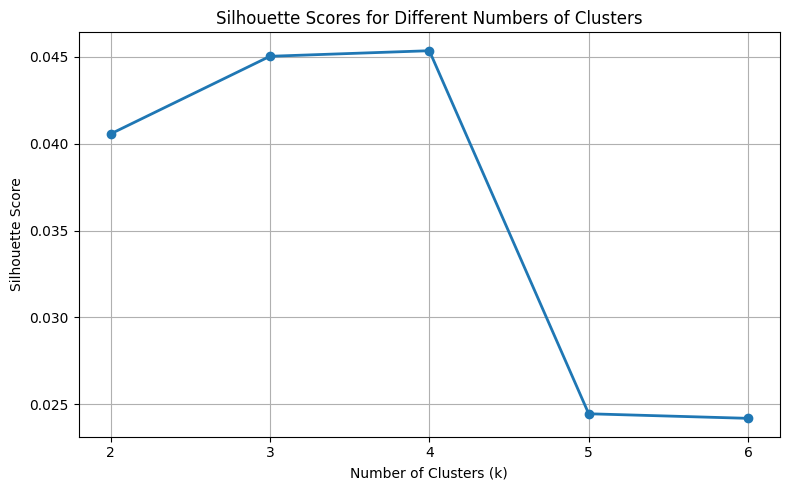

In [53]:

# Extract k values and silhouette scores (skip k=1 since it's None)
k_values = []
scores = []

for k, result in cluster_results.items():
    if result['score'] is not None:
        k_values.append(k)
        scores.append(result['score'])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_values, scores, marker='o', linestyle='-', linewidth=2)
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Identify the Best k

In [54]:
# Find the best k based on the highest silhouette score
best_k = max(
    {k: v['score'] for k, v in cluster_results.items() if v['score'] is not None},
    key=lambda k: cluster_results[k]['score']
)

print(f"Best k based on silhouette score: {best_k}")

Best k based on silhouette score: 4


#### Cluster the embeddings using 3 clusters (k=3)

In [55]:
# Apply KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(embedding_matrix)

# Assign the resulting cluster labels to the dataframe
df_news_unique['CLUSTER'] = cluster_labels

# Optional: Display distribution
print("✅ Clustering complete.")
print(df_news_unique['CLUSTER'].value_counts().sort_index())

✅ Clustering complete.
CLUSTER
0    112
1    236
2    153
Name: count, dtype: int64


### Visualize the 2 first PCA Components of your embeddings

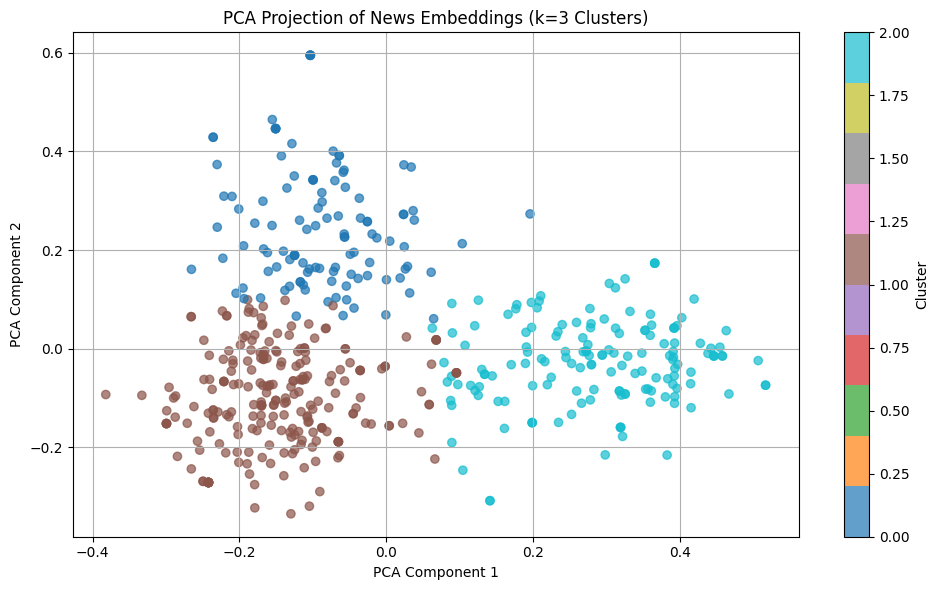

In [56]:
# Reduce to 2D using PCA
pca = PCA(n_components=2, random_state=42)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Add PCA results to the DataFrame
df_news_unique['PCA1'] = reduced_embeddings[:, 0]
df_news_unique['PCA2'] = reduced_embeddings[:, 1]

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_news_unique['PCA1'],
    df_news_unique['PCA2'],
    c=df_news_unique['CLUSTER'],
    cmap='tab10',
    alpha=0.7
)
plt.title("PCA Projection of News Embeddings (k=3 Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [57]:
# Loop through each cluster
for cluster_id in sorted(df_news_unique['CLUSTER'].unique()):
    print(f"\n\n📦 Cluster {cluster_id} — {len(df_news_unique[df_news_unique['CLUSTER'] == cluster_id])} articles")
    print("-" * 80)

    cluster_df = df_news_unique[df_news_unique['CLUSTER'] == cluster_id]

    # Display sample articles
    for _, row in cluster_df.head(10).iterrows():
        print(f"TICKER: {row['TICKER']}")
        print(f"TITLE : {row['TITLE']}")
        print(f"SUMMARY: {row['SUMMARY'][:200]}")  # truncate long summaries
        print()

    print("=" * 80)




📦 Cluster 0 — 112 articles
--------------------------------------------------------------------------------
TICKER: A
TITLE : Agilent CFO Bob McMahon resigns
SUMMARY: Rodney Gonsalves, corporate controller and principal accounting officer, will take on interim CFO duties. Analysts said the company’s reaffirmed third-quarter guidance should reassure investors.

TICKER: ABNB
TITLE : Airbnb ‘take over’ now driving up Atlanta homeowners’ costs — here’s why insurance may be their next headache
SUMMARY: The relationship between short-term renters and risk.

TICKER: MO
TITLE : The FDA Just Approved Juul’s E-Cigarettes. Does That Make Altria Stock a Buy Here?
SUMMARY: Altria was an earlier investor in Juul. Will its FDA approval be good news for the Altria’s NJOY brand?

TICKER: AEP
TITLE : American Electric Power Company (AEP) Declares US$0.93 Quarterly Dividend Payable September 2025
SUMMARY: American Electric Power Company (AEP) recently affirmed its regular quarterly cash dividend of 93 

## Question section
Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

### Technical Understanding

#### How does the `SentenceTransformer` model convert text into embeddings? What kind of information do you think is captured in these embeddings?

YOUR WRITTEN RESPONSE HERE

SentenceTransformer uses transformer-based models (like BERT or its variants) to convert input text into fixed-size dense vector representations. These embeddings capture semantic meaning — not just word presence, but also context, syntax, and relationships. For example, the sentences “Apple stock is rising” and “Shares of Apple are going up” would have similar embeddings because they convey the same meaning.

#### Why do we use the combination of TITLE and SUMMARY instead of just one or the other?


YOUR WRITTEN RESONSE HERE

Combining both fields provides a richer representation of the news item. Titles are usually concise and attention-grabbing, while summaries offer more detail. Together, they create a more informative embedding, improving clustering and analysis accuracy.

#### Explain what the silhouette score represents and how it helped you determine the number of clusters.


YOUR WRITTEN RESPONSE HERE

The silhouette score measures how similar a data point is to its own cluster compared to other clusters. It ranges from -1 (bad clustering) to 1 (good clustering). By computing this score across different k values, we can select the value of k that maximizes this score — indicating that data points are well matched to their own cluster and clearly separated from others.

### Data Analysis and Interpretation

#### After assigning cluster labels, did you notice any thematic consistency within clusters? For each cluster, is there a main theme? Is there a tone or a function behind the news? Is there a specific content source type?


YOUR WRITTEN RESPONSE HERE

Cluster 0
- Main Theme: Traditional financial updates, dividends, valuation
- Tone / Function: Neutral, technical, investor-oriented
- Content Source Type: Bloomberg/Zacks-like institutional coverage


Cluster 1
- Main Theme: Investment advice, AI/growth picks, strategy
- Tone / Function: Prescriptive, opportunity-seeking
- Content Source Type: Blogs, analyst columns, financial YouTube

Cluster 2
- Main Theme: Market-moving events, macro risk, legal/political
- Tone / Function: News-driven, broader & narrative
- Content Source Type: Newswires, macro reporting, investigative

#### Were there clusters that seemed too broad or too specific? What might cause this in your data?


YOUR WRITTEN RESPONSE HERE

Cluster 0 – Relatively Well-Defined and Focused

Why? Most items are traditional financial disclosures — earnings reports, dividends, valuations, analyst revisions. The cluster is primarily descriptive and numeric.
Result: Probably the most specific and cleanest cluster. It serves a clear function: "just the facts" about corporate fundamentals.

Cluster 1 – Possibly Too Broad

Why? It groups both general investment advice (e.g., retirement strategies, “buy now” lists) and specific stock analyses (e.g., AMAT, ANSS). While these all relate to stock picking and personal finance, the range of topics spans dividend investing, AI growth investing, and value strategies.
Result: It’s topically coherent around "what to buy and why", but the diversity of tone and stock types (tech, energy, value) risks making this cluster slightly too broad.

Cluster 2 – Broad in Topic, Specific in Type

Why? While the news stories range from tariffs and legal settlements to AI industry battles and FDA policy, they all share a macro or event-driven tone. This is more of a “market-moving news” cluster.
Result: It's a well-scoped thematic cluster (macro/news), but broad in topic area because it aggregates different sectors and event types (legal, regulatory, geopolitical).

#### What role does PCA play in the visualization step? Why do we reduce to two dimensions, and what is lost in doing so?


YOUR WRITTEN RESPONSE HERE

PCA (Principal Component Analysis) reduces the high-dimensional embedding vectors into 2D for visualization. This helps us observe general clustering trends. However, reducing to two dimensions loses a lot of the original structure and subtle distinctions, potentially flattening separable clusters into overlapping visual regions.

### Critical Thinking

#### What are some limitations of this analysis approach in a real-world financial setting?

YOUR WRITTEN RESPONSE HERE

News coverage is uneven: Not all stocks have news at all times.
Embeddings may not capture financial nuance or factual correctness.
No temporal modeling — the pipeline ignores when the news was released and how recent it is.
No sentiment or price impact assessment is done, which are critical in finance.
Embedding models are not fine-tuned on financial data, which may lead to shallow understanding of domain-specific terms.

#### If you had access to more detailed news metadata (e.g., sentiment, category, author), how might you integrate that into your clustering pipeline?


YOUR WRITTEN RESPONSE HERE

You could:
- Add sentiment as an extra feature vector (or embed it directly).
- Filter or cluster separately by categories (e.g., legal, earnings).
- Group by author or source credibility to assess bias or quality.
- Use metadata to weight or filter certain types of news in training.

#### Suppose you're tasked with building a news recommendation engine using this embedding and clustering method. What would be your next steps?


YOUR WRITTEN RESPONSE HERE

- Assign users or stocks their own embedding vector based on interaction or price response history.
- Use cosine similarity between user vector and news embeddings to recommend top-k items.
- Incorporate time decay (recent news is weighted more).
- Continuously update clustering to adapt to new patterns.
- Add user feedback to fine-tune relevance.